In [12]:
import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import hj_reachability as hj


ImportError: cannot import name 'config' from 'jax' (unknown location)

In [ ]:
import pkgutil

# this is the package we are inspecting -- for example 'email' from stdlib

package = hj
for importer, modname, ispkg in pkgutil.iter_modules(package.__path__):
    print ("Found submodule %s (is a package: %s)" % (modname, ispkg))

Found submodule artificial_dissipation (is a package: False)
Found submodule boundary_conditions (is a package: False)
Found submodule boundary_conditions_test (is a package: False)
Found submodule dynamics (is a package: False)
Found submodule finite_differences (is a package: True)
Found submodule grid (is a package: False)
Found submodule interpolation (is a package: False)
Found submodule sets (is a package: False)
Found submodule shapes (is a package: False)
Found submodule solver (is a package: False)
Found submodule solver_test (is a package: False)
Found submodule systems (is a package: True)
Found submodule time_integration (is a package: False)
Found submodule utils (is a package: False)
Found submodule viz (is a package: False)


In [ ]:
# need to overwrite a bunch
import functools

import jax
import jax.numpy as jnp
import numpy as np

from hj_reachability import utils

gamma = 1

def lax_friedrichs_numerical_hamiltonian(hamiltonian, state, time, value, left_grad_value, right_grad_value,
                                         dissipation_coefficients):
    hamiltonian_value = hamiltonian(state, time, value, (left_grad_value + right_grad_value) / 2)
    dissipation_value = dissipation_coefficients @ (right_grad_value - left_grad_value) / 2
    return hamiltonian_value - dissipation_value


@functools.partial(jax.jit, static_argnames="dynamics")
def euler_step(solver_settings, dynamics, grid, time, values, time_step=None, max_time_step=None):
    time_direction = jnp.sign(max_time_step) if time_step is None else jnp.sign(time_step)
    signed_hamiltonian = lambda *args, **kwargs: time_direction * dynamics.hamiltonian(*args, **kwargs)
    left_grad_values, right_grad_values = grid.upwind_grad_values(solver_settings.upwind_scheme, values)
    dissipation_coefficients = solver_settings.artificial_dissipation_scheme(dynamics.partial_max_magnitudes,
                                                                             grid.states, time, values,
                                                                             left_grad_values, right_grad_values)
    dvalues_dt = -solver_settings.hamiltonian_postprocessor(time_direction * utils.multivmap(
        lambda state, value, left_grad_value, right_grad_value, dissipation_coefficients:
        (lax_friedrichs_numerical_hamiltonian(signed_hamiltonian, state, time, value,
                                              left_grad_value, right_grad_value, dissipation_coefficients)),
        np.arange(grid.ndim))(grid.states, values, left_grad_values, right_grad_values, dissipation_coefficients))
    if time_step is None:
        time_step_bound = 1 / jnp.max(jnp.sum(dissipation_coefficients / jnp.array(grid.spacings), -1))
        time_step = time_direction * jnp.minimum(solver_settings.CFL_number * time_step_bound, jnp.abs(max_time_step))
    # TODO: Think carefully about whether `solver_settings.value_postprocessor` should be applied here instead.
    return time + time_step, values + time_step * dvalues_dt


def first_order_total_variation_diminishing_runge_kutta(solver_settings, dynamics, grid, time, values, target_time):
    time_1, values_1 = euler_step(solver_settings, dynamics, grid, time, values, max_time_step=target_time - time)
    return time_1, solver_settings.value_postprocessor(time_1, values_1)


def second_order_total_variation_diminishing_runge_kutta(solver_settings, dynamics, grid, time, values, target_time):
    time_1, values_1 = euler_step(solver_settings, dynamics, grid, time, values, max_time_step=target_time - time)
    time_step = time_1 - time
    _, values_2 = euler_step(solver_settings, dynamics, grid, time_1, values_1, time_step)
    return time_1, solver_settings.value_postprocessor(time_1, (values + values_2) / 2)


def third_order_total_variation_diminishing_runge_kutta(solver_settings, dynamics, grid, time, values, target_time):
    time_1, values_1 = euler_step(solver_settings, dynamics, grid, time, values, max_time_step=target_time - time)
    time_step = time_1 - time
    _, values_2 = euler_step(solver_settings, dynamics, grid, time_1, values_1, time_step)
    time_0_5, values_0_5 = time + time_step / 2, (3 / 4) * values + (1 / 4) * values_2
    _, values_1_5 = euler_step(solver_settings, dynamics, grid, time_0_5, values_0_5, time_step)
    return time_1, solver_settings.value_postprocessor(time_1, (1 / 3) * values + (2 / 3) * values_1_5)

hj.time_integration.lax_friedrichs_numerical_hamiltonian = lax_friedrichs_numerical_hamiltonian
hj.time_integration.euler_step = euler_step

Moore-Greitzer jet engine model

In [ ]:
# If we formulate it as affine systems the optimization is taken care for automatically!
class MooreGreitzerJet(hj.ControlAndDisturbanceAffineDynamics):
    """ The 2D Agent implemented as an Affine Dynamics system.
    Operating in a static flow field with currents in x and y direction.

    Dynamics:
    dot{x}_1 = u_x + x_current + D_1
    dot{x}_2 = u_y + y_current + D_2
    such that ||(u_x, u_y)|| < u_max
    """

    def __init__(self,
                 u_max=0.01, d_max=0.02,
                 x_current=10., y_current=10.,
                 control_mode="min",
                 disturbance_mode="max",
                 gamma=1):
        # set constants
        self.u_max = u_max

        # # what is x current here
        # self.x_current = jnp.array(x_current)
        # self.y_current = jnp.array(y_current)

        self.gamma=gamma

        control_space = hj.sets.Box(jnp.array([-0.01]), jnp.array([0.01]))
        disturbance_space = hj.sets.Box(jnp.array([-0.04]), jnp.array([0.04]))
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    # i assumed as if u=0
    def open_loop_dynamics(self, state, time):
        """Define the open-loop dynamics (without control input)."""
        x, y = state
        return jnp.array([-y-(3/2)*(x**2)-(1/2)*(x**3), 0.8076*x-0.9424*y])

    def control_jacobian(self, state, time):
        """Define the Control Jacobian matrix (d_dot{x}_i/d_u_j)."""
        x, y = state
        return jnp.array([
            [0.],
            [x],
        ])

    def disturbance_jacobian(self, state, time):
        x, y = state
        return jnp.array([
            [1.],
            [0.],
        ])

    # overwrite hamiltonion
    def hamiltonian(self, state, time, value, grad_value):
        """Evaluates the HJ PDE Hamiltonian."""
        #del value  # unused
        control, disturbance = self.optimal_control_and_disturbance(state, time, grad_value)
        return -self.gamma*value + grad_value @ self(state, control, disturbance, time)

dynamics = MooreGreitzerJet()

grid_xlow = -0.51
grid_xhigh = 0.51
grid_ylow = -0.51
grid_yhigh = 0.51
num_points = 400
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([grid_xlow, grid_ylow]),
                                                                           np.array([grid_yhigh, grid_yhigh])),
                                                               (num_points, num_points))

# x_target = [0, 0]
# r_target = 0.5
# values = -hj.shapes.shape_sphere(grid=grid, center=x_target, radius=r_target)

def dirichlet(x, pad_width: int):
    return jnp.pad(x, ((pad_width, pad_width)), "constant", constant_values=0.2)

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain = hj.sets.Box(lo=np.array([grid_xlow, grid_ylow]), hi=np.array([grid_xhigh, grid_yhigh])),
    shape = (num_points, num_points),
    # Boundary conditions matter for accuracy on the edge of the domain grid.
    # E.g. if we have an angle theta \in [0, 2pi] then we want a periodic boundary in that dim.
    boundary_conditions=(dirichlet, dirichlet)
)

# # Create the 2D grid
x = np.linspace(grid_xlow, grid_xhigh, num=num_points)
y = np.linspace(grid_ylow, grid_yhigh, num=num_points)
X, Y = np.meshgrid(x, y)
def h(x, y):
  return (x**2 + y**2 - 0.25) / (1 + (x**2 + y**2 - 0.25)**2)
values = h(grid.states[:, :, 0], grid.states[:, :, 1])
hamiltonian_postprocessor=hj.solver.backwards_reachable_tube
# hamiltonian_postprocessor = lambda x, v: jnp.minimum(x, 0)
static_obstacle = lambda obstacle: (lambda t, v: jnp.maximum(v, obstacle))
value_postprocessor = static_obstacle(values)

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  value_postprocessor=value_postprocessor)

In [ ]:
print(X.shape)
print(grid.states.shape)

(400, 400)
(400, 400, 2)


In [ ]:
times = np.linspace(0, -5, 57)
initial_values = values
times, all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########|  5.0000/5.0 [00:05<00:00,  1.02s/sim_s]


In [ ]:
print(all_values.shape)
print(all_values[-1])

(57, 400, 400)
[[0.25181544 0.24971698 0.2476205  ... 0.3835693  0.3845564  0.38554284]
 [0.24971698 0.24760988 0.24550489 ... 0.3813733  0.3823618  0.38334957]
 [0.2476205  0.24550489 0.24339144 ... 0.3791772  0.38016722 0.38115638]
 ...
 [0.2476205  0.24550489 0.24339144 ... 0.24339144 0.24550489 0.2476205 ]
 [0.24971698 0.24760988 0.24550489 ... 0.24550489 0.24760988 0.24971698]
 [0.25181544 0.24971698 0.2476205  ... 0.2476205  0.24971698 0.25181544]]


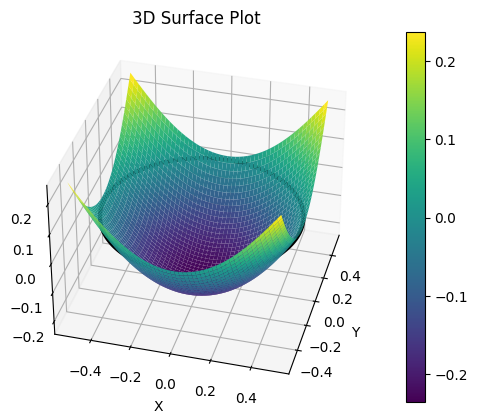

In [ ]:
# Create a 2D grid of x and y values
x = np.linspace(grid_xlow, grid_xhigh, num_points)
y = np.linspace(grid_ylow, grid_yhigh, num_points)
X, Y = np.meshgrid(x, y)

# Replace this with your own array of float values
# For example, generating random data for demonstration purposes
arr = values

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Create the 3D surface plot
surface = ax.plot_surface(X, Y, arr, cmap='viridis')
contour = plt.contour(X, Y, arr, levels=[0], colors='black', linewidths=3)

ax.view_init(elev=35, azim=15)

# Add a colorbar which maps values to colors
fig.colorbar(surface)

# Set labels for the axes
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')


ax.invert_xaxis()

# Set a title for the plot
plt.title('3D Surface Plot')

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

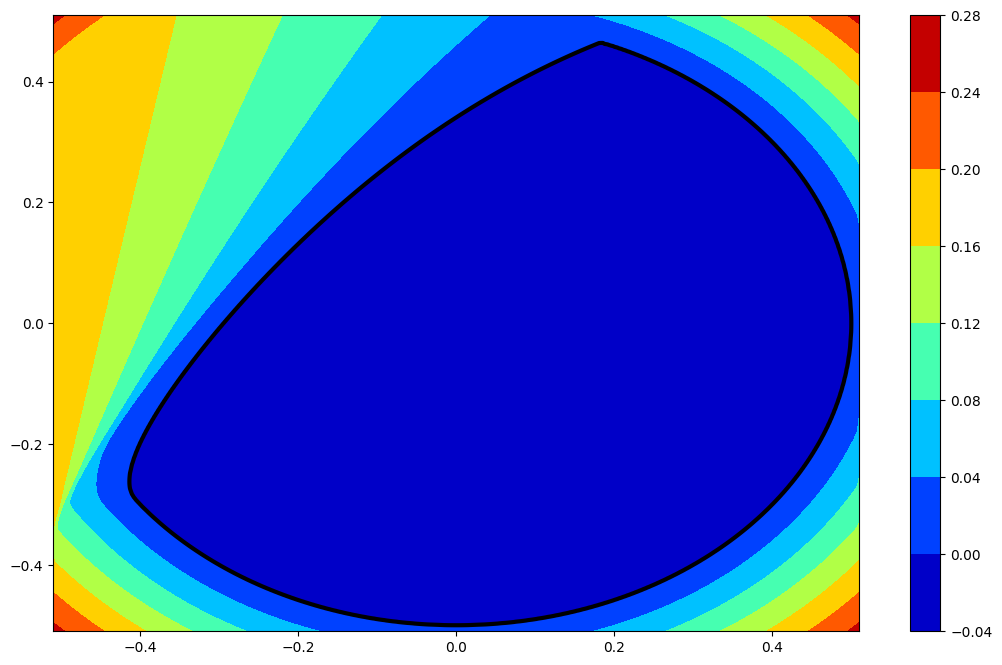

In [ ]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], all_values[-1, :, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            all_values[-1, :, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [ ]:
# Animate the set evolution (Various extra options available)
hj.viz.visSet2DAnimation(grid, all_values, times,
# include the value function levels
#                          colorbar=True
# can also save it as mp4 or gif
#                       type='mp4', filename='2D_reachability_animation',
                        )
# => for more options see documentation

In [ ]:
print(all_values[-1].shape)

(100, 100)


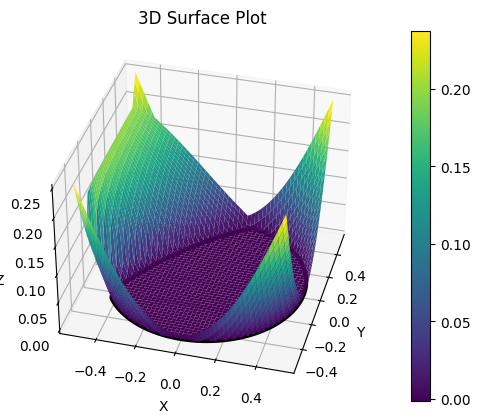

In [ ]:
# Create a 2D grid of x and y values
x = np.linspace(grid_xlow, grid_xhigh, num_points)
y = np.linspace(grid_ylow, grid_yhigh, num_points)
X, Y = np.meshgrid(x, y)

# Replace this with your own array of float values
# For example, generating random data for demonstration purposes
arr = all_values[-1]

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Create the 3D surface plot
surface = ax.plot_surface(X, Y, arr, cmap='viridis')
contour = plt.contour(X, Y, arr, levels=[0], colors='black', linewidths=3)

ax.view_init(elev=35, azim=15)

# Add a colorbar which maps values to colors
fig.colorbar(surface)

# Set labels for the axes
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')


ax.invert_xaxis()

# Set a title for the plot
plt.title('3D Surface Plot')

# Show the plot
plt.show()